# Cowardly Shots from Afar

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from fractions import Fraction
import matplotlib.pyplot as plt

In [2]:
sns.set_theme()

In [3]:
### Irrelevant really
### A small utility function for converting fractions to dice rolls
def fraction_to_roll(fraction):
    if fraction == 0:
        return "-"

    if fraction == Fraction(1, 12):
        return "(6+,4+)"
    
    if fraction == Fraction(1, 18):
        return "(6+,5+)"
    
    if fraction == Fraction(1, 36):
        return "(6+,6+)"
    
    return {Fraction(n, 6): "{}+".format(7-n) for n in range(1, 6)}.get(fraction)

## Understanding Shooting

Tabletop Warhammer uses fewer stats than melee for shooting but is more dependent on terrain and distance to the target

Ballistic Skill (BS) - The only stat that matters, how good are you at hitting your target

For the defender, Toughness (T), Save and Ward are still important

### Roll to Shoot

Roll to Shoot depends on an overall Hit Score which is a function of BS + hit modifiers, a BS of 3 corresponds to a base modifier of 0, a 1/2 (4+) to hit.

This base modifier changes linearly with BS
* A BS of 2 corresponds to a Hit Score of -1, 1/3 (5+) to hit
* A BS of 1 corresponds to a Hit Score of -2, 1/6 (6+) to hit

Similary
* A BS of 4 corresponds to a Hit Score of 1, 2/3 (3+) to hit
* A BS of 5 corresponds to a Hit Score of 2, 5/6 (2+) to hit

While the Hit Score keeps increasing you can't ever do better than a 2+ to hit, it mainly comes into play when combined with other, usually negative, modifiers.

_Unlike_ melee combat though, you can do a lot worse than a 6+
* A total modifier of -3 gives you a 1/12 (6+,4+) to hit
* A total modifier of -4 gives you a 1/18 (6+,5+) to hit
* A total modifier of -5 gives you a 1/36 (6+, 6+) to hit
* Anything less than this gives you no chance to hit

In [4]:
def roll_to_shoot(attackers_bs, modifier):
    
    hit_score = attackers_bs - 3 + modifier
    
    if -3 < hit_score < 3:
        return Fraction(hit_score + 3, 6)
    
    if 3 <= hit_score:
        return Fraction(5, 6)
    
    if -6 < hit_score <= -3:
        return {-3: Fraction(1, 12),
                -4: Fraction(1, 18),
                -5: Fraction(1, 36)}.get(hit_score)

    return Fraction(0, 6)

In [5]:
to_shoot_table = (pd.DataFrame([(a, m, roll_to_shoot(a, m)) for a in range(1, 11) for m in range(-4, 5)],
                               columns=["attacker_bs", "modifier", "to_shoot"])
                  .set_index(["attacker_bs", "modifier"]))

print(len(to_shoot_table))
to_shoot_table.loc[1]

90


,to_shoot
modifier,
-4,0
-3,1/36
-2,1/18
-1,1/12
0,1/6
1,1/3
2,1/2
3,2/3
4,5/6


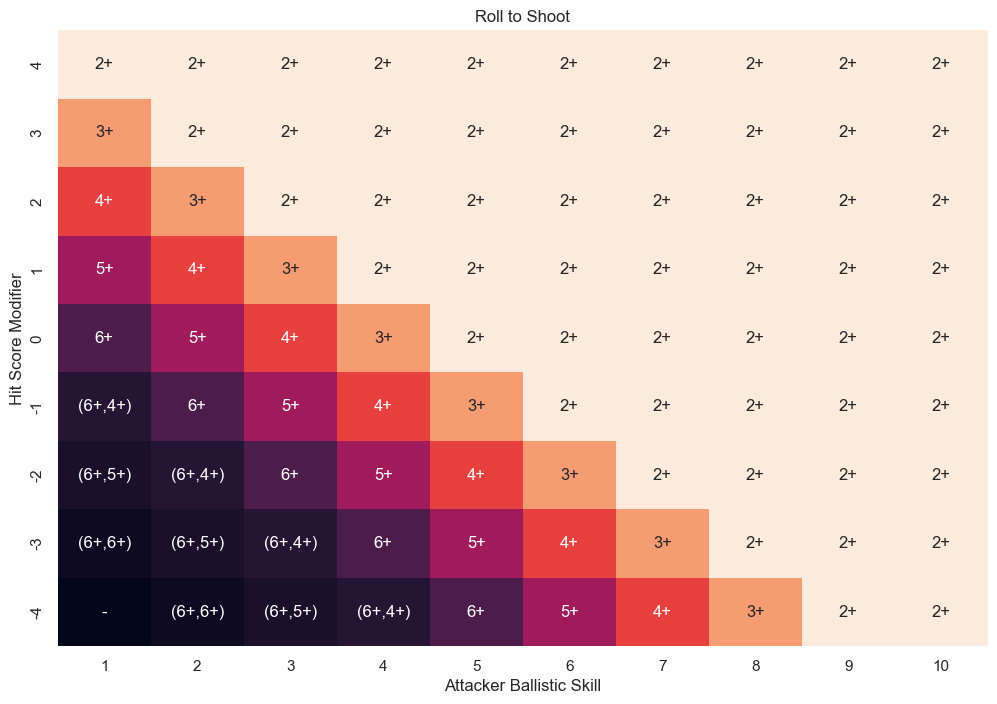

In [6]:
data = (to_shoot_table
        .pivot_table(index="modifier", columns="attacker_bs", values="to_shoot")
        .sort_index(ascending=False))

annot = (to_shoot_table
         .assign(label=to_shoot_table["to_shoot"].apply(fraction_to_roll))
         .reset_index()
         .pivot(index="modifier", columns="attacker_bs", values="label")
         .sort_index(ascending=False))

f, ax = plt.subplots(1, 1)
f.set_size_inches(12, 8)
sns.heatmap(data, annot=annot.values, ax=ax, fmt="", cbar=False)
ax.set_title("Roll to Shoot")
ax.set_xlabel("Attacker Ballistic Skill")
ax.set_ylabel("Hit Score Modifier");